In [1]:
%pylab inline
import os # for path joining per os

Populating the interactive namespace from numpy and matplotlib


# Fastcat Hybrid MC Spectral Cone Beam CT Data

Here is a brief excerpt from the previous assignment to explain the data:

Cone Beam CT (CBCT) is a type of CT scan used in radiotherapy patient positioning. Cone beam CT only requires one rotation to provide a CT volume of a patient as opposed to the hundreds of rotations usually acquired in conventional CT making it convenient for quick confirmation that the patient's setup position matches the position of the CT scan that was used by the medical physicist and radiation oncologist to plan the treatment as discrepancy between the planning CT and patient position during treatment is associated with failure to control tumour growth and increase normal tissue side effects.

We can use this information about the energy to learn more about the material composition of the patient which will help with segmentation of structures as well as identification of patient tissue compositions which is integral to the dose calculations used in radiation oncology.

Here we simulate the output of a spectral CT scan of a patients head with binning of photons into seven energy bins and plan to use a machine learning method to functionally approximate patient tissue density.

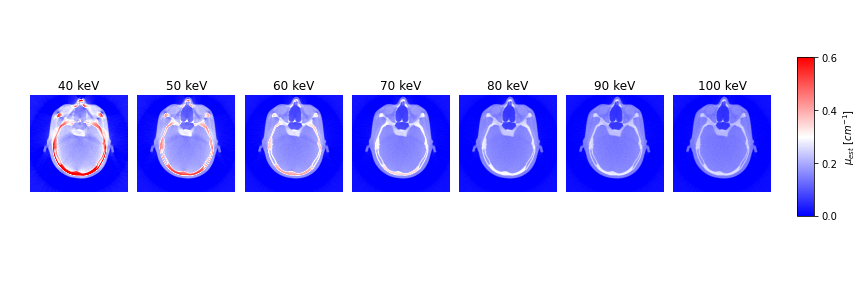
A visualualization of the feature data in the image space

## The assignment question is as follows:

3- Use your data and find the best hyperparameters of a KNN model, K and p, (for a regression) using GridSearch.

#### This is similar code to last assignment as I used grid seach last assignment

In [2]:
#Import packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, ParameterGrid, RepeatedStratifiedKFold, GridSearchCV
from sklearn import linear_model
import matplotlib.gridspec as gridspec
import pandas as pd

### Load the data from numpy files

In [3]:
X = np.load(os.path.join('sample_data_joconnell','spectral_inp_data.npy'))
# I ended up adding a gaussian filter to the density data to make it non-discrete and a little more interesting for regression 
Y = np.load(os.path.join('sample_data_joconnell','spectral_tar_density_gaus_filt.npy'))

### Making the Dataset smaller in this instance

Don't want looking for k and p to take forever in the grid search

In [4]:
# Split for validation set
X_tr, X_va, Y_tr, Y_va = train_test_split(X, Y, test_size=2500, train_size=10000)

print('training set == ', np.shape(X_tr), np.shape(Y_tr),
      ', validation set == ', np.shape(X_va), np.shape(Y_va))

training set ==  (10000, 7) (10000,) , validation set ==  (2500, 7) (2500,)


## Apply normalization

I won't go through how the distributions look under normalization again because it is the same as the first notebook. But a discussion of this is in the first notebook!

### Normalized Data

#### Applying the standard scaler to the data

In [5]:
# Apply the standard scaler
scaler_S = StandardScaler().fit(X_tr) # Only fit on the training
X_tr_Norm = scaler_S.transform(X_tr)
X_va_Norm = scaler_S.transform(X_va)

#### The standard scaler really spread out the data and pushed the mean back from ~0.2 to 0

## Applying the KNN Regressor with Normalization


### Initialize the KNN and using a grid search

In [6]:
# Make a parameter grid with different p's and k's
param_grid = [
    {"n_neighbors": [1,2,3,5,8,13,21,34,55,89,144,233], # fibonacci seemed good
    "p": [1,2]}
]

# Initialize an empty regressor
reg = KNeighborsRegressor()
# Initialize a K-Fold cross validator
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
# Initialize the grid search algorithm
search = GridSearchCV(estimator=reg, param_grid=param_grid,n_jobs=8,return_train_score=True)
# Perform the grid search
search.fit(X_tr_Norm, Y_tr)

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=8,
             param_grid=[{'n_neighbors': [1, 2, 3, 5, 8, 13, 21, 34, 55, 89,
                                          144, 233],
                          'p': [1, 2]}],
             return_train_score=True)

### Look at the Performance from the grid search in a dataframe (from sklearn example)

In [7]:
results_df = pd.DataFrame(search.cv_results_) # make a dataframe
results_df = results_df.sort_values(by=["rank_test_score"]) # Sort by test score
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel") # give descriptive name
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score","mean_train_score","std_train_score"]] # Look at mean and variation in scores

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
kernel,,,,,,
21_2,"{'n_neighbors': 21, 'p': 2}",1,0.932489,0.003306,0.939033,0.000884
34_2,"{'n_neighbors': 34, 'p': 2}",2,0.932256,0.003305,0.936596,0.000802
34_1,"{'n_neighbors': 34, 'p': 1}",3,0.931907,0.003402,0.936441,0.000905
21_1,"{'n_neighbors': 21, 'p': 1}",4,0.931850,0.002940,0.938653,0.000898
13_2,"{'n_neighbors': 13, 'p': 2}",5,0.931553,0.003320,0.941722,0.000950
55_2,"{'n_neighbors': 55, 'p': 2}",6,0.931058,0.003117,0.934254,0.000846
55_1,"{'n_neighbors': 55, 'p': 1}",7,0.930979,0.003244,0.934038,0.000942
13_1,"{'n_neighbors': 13, 'p': 1}",8,0.930721,0.003417,0.941116,0.000865
8_2,"{'n_neighbors': 8, 'p': 2}",9,0.928975,0.003356,0.945459,0.001008


#### The K = 21 and p = 1 has the best score with similar scores for the surrounding trials indicating that anywhere between 10-30 neighbors should return good results. The choice between p = 1 and 2 doesn't seem to correlate to better performance.

#### The standard deviation of the score was quite small but a little larger for 21, 2 than 21, 1 indicating that L1 regularization might give more dependable results perhaps.

### Plotting the highest performing (Just for fun)

In [9]:
# Use all of the data again
X_tr, X_va, Y_tr, Y_va = train_test_split(X, Y, test_size=0.2)
# Apply the standard scaler
scaler_S = StandardScaler().fit(X_tr) # Only fit on the training
X_tr_Norm = scaler_S.transform(X_tr)
X_va_Norm = scaler_S.transform(X_va)

reg = KNeighborsRegressor(n_neighbors=21, p=1) 

reg.fit(X_tr_Norm,Y_tr)  # fit the model with the normalized training set

#predictions for training and validation sets
Y_tr_pred_Norm = reg.predict(X_tr_Norm)  
Y_va_pred_Norm = reg.predict(X_va_Norm)

### A fairly fancy plot showing the histogram of the two distributions, their cumulative and the scatter

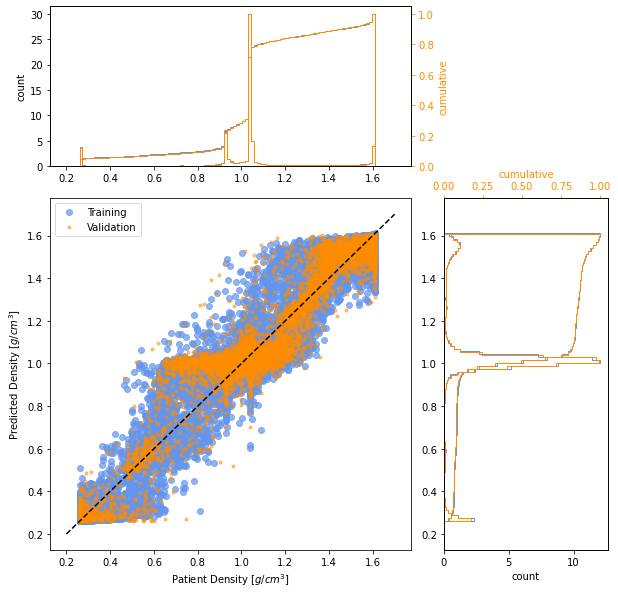

In [10]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

# Main scatter plots
ax_main.plot(Y_tr,Y_tr_pred_Norm,'o',c='cornflowerblue',alpha=0.7,lw=0.1)
ax_main.plot(Y_va,Y_va_pred_Norm,'.',c='darkorange',alpha=0.5,lw=0.1)
ax_main.plot(np.arange(0.2,1.8,.1),  np.arange(0.2,1.8,.1),'--k')
ax_main.set(xlabel="Patient Density [$g/cm^3$]", ylabel="Predicted Density [$g/cm^3$]")
ax_main.legend(['Training', 'Validation'])

# x Histogram (Normalized) and x Cummulative
ax_xDist.hist(Y_tr,bins=100,align='mid',histtype='step',color='cornflowerblue',density=True)
ax_xDist.hist(Y_va,bins=100,align='mid',histtype='step',color='darkorange',density=True)
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(Y_tr,bins=100,cumulative=True,histtype='step',density=True,color='cornflowerblue',align='mid')
ax_xCumDist.hist(Y_va,bins=100,cumulative=True,histtype='step',density=True,color='darkorange',align='mid')
ax_xCumDist.tick_params('y', colors='darkorange')
ax_xCumDist.set_ylabel('cumulative',color='darkorange')

# y Histogram (Normalized) and y Cummulative
ax_yDist.hist(Y_tr_pred_Norm,bins=100,orientation='horizontal',align='mid',histtype='step',density=True,color='cornflowerblue')
ax_yDist.hist(Y_va_pred_Norm,bins=100,orientation='horizontal',align='mid',histtype='step',density=True,color='darkorange')
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(Y_tr_pred_Norm,bins=100,cumulative=True,histtype='step',density=True,color='cornflowerblue',align='mid',orientation='horizontal')
ax_yCumDist.hist(Y_va_pred_Norm,bins=100,cumulative=True,histtype='step',density=True,color='darkorange',align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors='darkorange')
ax_yCumDist.set_xlabel('cumulative',color='darkorange')

plt.show()

#### The model still can't seem to seperate the two peaks

### Model performance

In [11]:
# Statistical information regarding training and validation predictions

# Compute descriptive statistics
mu = np.mean(Y_tr-Y_tr_pred_Norm)
median = np.median(Y_tr-Y_tr_pred_Norm)
sigma = np.std(Y_tr-Y_tr_pred_Norm)

muv = np.mean(Y_va-Y_va_pred_Norm)
medianv = np.median(Y_va-Y_va_pred_Norm)
sigmav = np.std(Y_va-Y_va_pred_Norm)

print(f'\nThe mean error, median error, and standard deviation of the error were {mu:2.4f}, {median:2.4f}, {sigma:2.4f} for the training set and {muv:2.4f}, {medianv:2.4f}, {sigmav:2.4f} for the validation set.')

print(f'\nThe difference in the mean error, median error, and standard deviation of the error between training and validation sets was {(mu - muv):2.4f}, {median-medianv:2.4f}, {sigma-sigmav:2.4f}.')


The mean error, median error, and standard deviation of the error were 0.0019, 0.0143, 0.0679 for the training set and 0.0016, 0.0149, 0.0714 for the validation set.

The difference in the mean error, median error, and standard deviation of the error between training and validation sets was 0.0003, -0.0007, -0.0035.


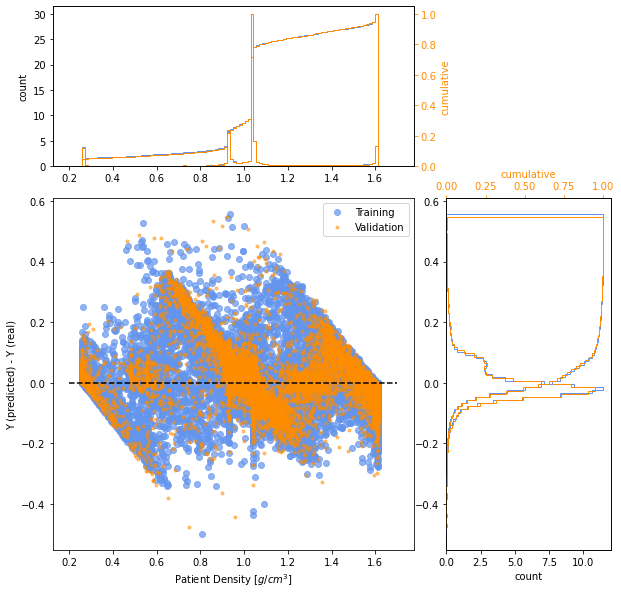

In [12]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

c1, c2 = 'cornflowerblue', 'darkorange'

# Main scatter plots
ax_main.plot(Y_tr,Y_tr_pred_Norm-Y_tr,'o',c=c1,alpha=0.7,lw=0.1)
ax_main.plot(Y_va,Y_va_pred_Norm-Y_va,'.',c=c2,alpha=0.5,lw=0.1)
ax_main.plot([0.2,1.7], [0,0],'--k')
ax_main.set(xlabel="Patient Density [$g/cm^3$]", ylabel="Y (predicted) - Y (real)")
ax_main.legend(['Training', 'Validation'])

# x Histogram (Normalized) and x Cummulative
ax_xDist.hist(Y_tr,bins=100,align='mid',histtype='step',color=c1,density=True)
ax_xDist.hist(Y_va,bins=100,align='mid',histtype='step',color=c2,density=True)
ax_xDist.set(ylabel='count')
ax_xCumDist = ax_xDist.twinx()
ax_xCumDist.hist(Y_tr,bins=100,cumulative=True,histtype='step',density=True,color=c1,align='mid')
ax_xCumDist.hist(Y_va,bins=100,cumulative=True,histtype='step',density=True,color=c2,align='mid')
ax_xCumDist.tick_params('y', colors=c2)
ax_xCumDist.set_ylabel('cumulative',color=c2)

# y Histogram (Normalized) and y Cummulative
ax_yDist.hist(Y_tr_pred_Norm-Y_tr,bins=100,orientation='horizontal',align='mid',histtype='step',density=True,color=c1)
ax_yDist.hist(Y_va_pred_Norm-Y_va,bins=100,orientation='horizontal',align='mid',histtype='step',density=True,color=c2)
ax_yDist.set(xlabel='count')
ax_yCumDist = ax_yDist.twiny()
ax_yCumDist.hist(Y_tr_pred_Norm-Y_tr,bins=100,cumulative=True,histtype='step',density=True,color=c1,align='mid',orientation='horizontal')
ax_yCumDist.hist(Y_va_pred_Norm-Y_va,bins=100,cumulative=True,histtype='step',density=True,color=c2,align='mid',orientation='horizontal')
ax_yCumDist.tick_params('x', colors=c2)
ax_yCumDist.set_xlabel('cumulative',color=c2)

plt.show()

#### It looks quite similar to the k=10 that I used in the first notebook in the first assignment, which was indicated by the performance in the grid search above.